In [1]:
# Create a Simulate Environment

# Imports

In [185]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import librosa
import torchaudio.transforms as T
import os



%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

from environment import LinearArray
from audio_datasets import YesNoDataset

# Test the Beamforming Environment

8000


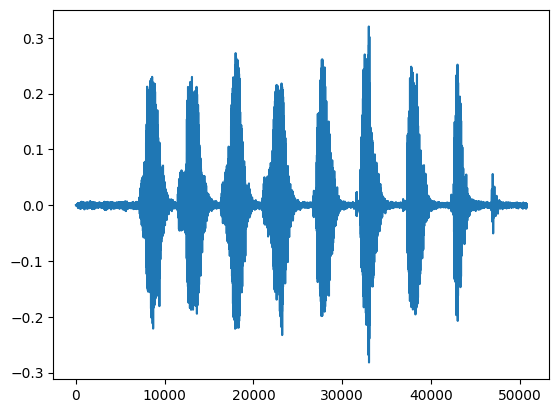

In [53]:
dataset = torchaudio.datasets.YESNO('.', download=True)
audio_path = '/home/ms4/Desktop/research/beamforming/waves_yesno/0_0_0_0_1_1_1_1.wav'
signal, sample_rate = librosa.load(audio_path, sr=None) #sr=None preserves original sample rate

print(sample_rate)
plt.plot(signal)

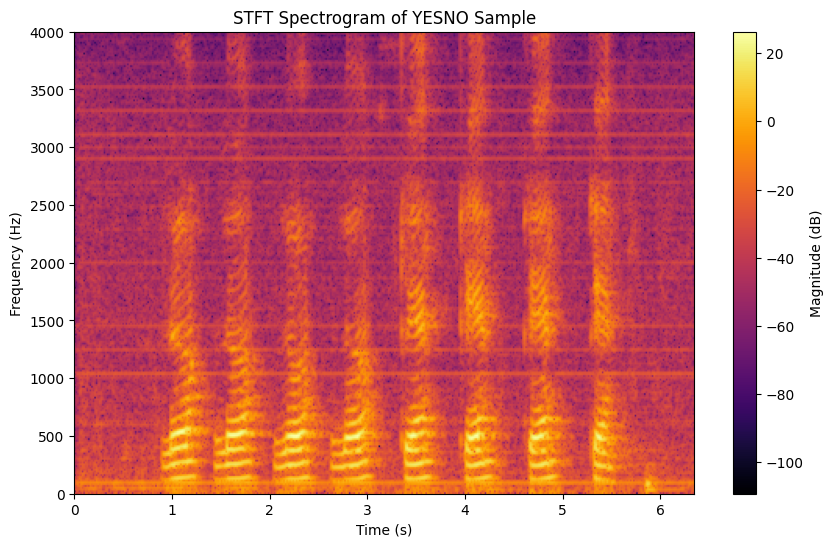

In [ ]:
# Define STFT parameters
n_fft = 512
win_length = 512
hop_length = 128

# Compute STFT
stft_transform = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=None)
spectrogram = stft_transform(torch.tensor(signal))  # Shape: (num_channels, num_freq_bins, num_time_frames)

# Convert to magnitude spectrogram
magnitude = spectrogram.abs().squeeze(0)  # Remove channel dim if mono

# Plot spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(20 * torch.log10(magnitude + 1e-6).numpy(), aspect='auto', origin='lower', cmap='inferno', 
           extent=[0, signal.shape[-1] / sample_rate, 0, sample_rate / 2])
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("STFT Spectrogram of YESNO Sample")
plt.show()

Text(0.5, 0, 'Frequency (Hz)')

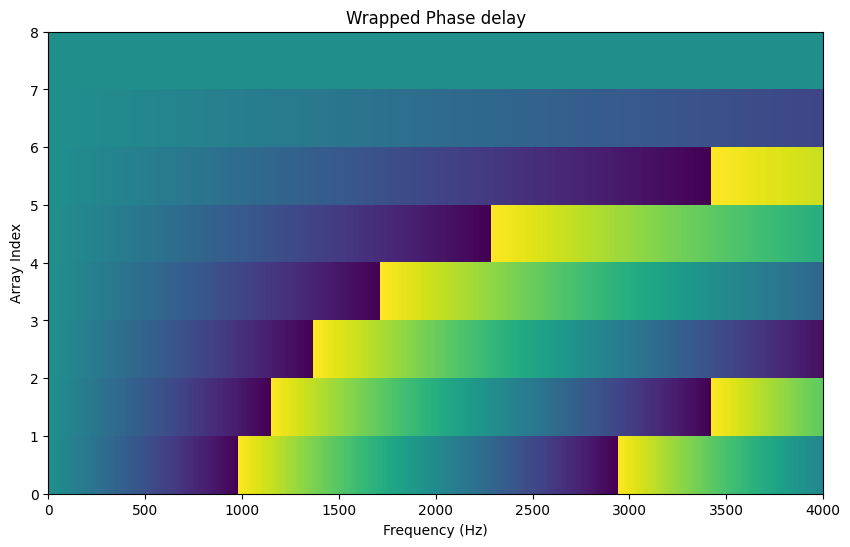

In [ ]:
# APPLY SHIFTS TO 

M = 8
N = spectrogram.shape[1]
Nf = spectrogram.shape[0]
theta = torch.tensor(30)
c = 343

d = 0.05
sample_rate = 8000

# f and t axis for spectrogram
t_axis = torch.linspace(0, signal.shape[0] , steps=N)
f_axis = torch.linspace(0, sample_rate/2, steps=Nf)

# (M,Nf,N)
# STEERING VECTOR
# Arr Position (M,1)
pos = torch.tensor([i*d for i in range(M)]).view(-1,1)
tau = -(pos * torch.sin(torch.deg2rad(theta)))/c # (M,1)
phi = 2*np.pi*tau @ f_axis.view(1,-1) # (M,Nf)
s_vec = torch.exp(1j*phi)

# Apply product to the spectrogram (Nf,N)
shifted_spectrogram = s_vec.unsqueeze(-1) * spectrogram.unsqueeze(0)
    

f,ax = plt.subplots(1,1,figsize=(10,6))

ax.imshow(torch.angle(s_vec),extent=[f_axis[0],f_axis[-1],0,M],aspect='auto')
ax.set_title('Wrapped Phase delay')
ax.set_ylabel('Array Index')
ax.set_xlabel('Frequency (Hz)')

In [ ]:
linear_array()

In [179]:
inv_spectrogram_transform =  T.InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length)
X = inv_spectrogram_transform(shifted_spectrogram)

(10000.0, 10050.0)

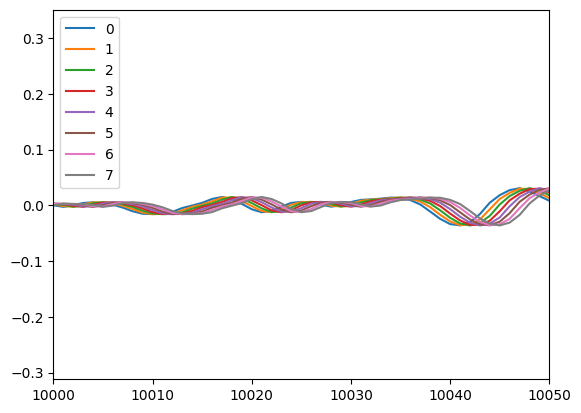

In [180]:
for i in range(M):
    plt.plot(X[i,:])
plt.legend([str(i) for i in range(M)])
plt.xlim(10000,10050)

In [191]:
dataset = YesNoDataset(audio_path='./waves_yesno')

# Test len and load
print(len(dataset))
i = 4
signal,fs = dataset[i]
print('Signal shape:',signal.shape,'\n Sampling rate:',fs)

60
Signal shape: (50480,) 
 Sampling rate: 8000


## Linear Array

In [243]:
M = 8
L = 2000
d = 0.05
fs = 8000
lin_arr = LinearArray(M,L,d,fs)

In [244]:
# Load signal
lin_arr.add_signal(torch.tensor(signal).view(1,-1),theta=30)

In [247]:
# Read Sensor
X = lin_arr.read_sensor(30)

(8000.0, 8050.0)

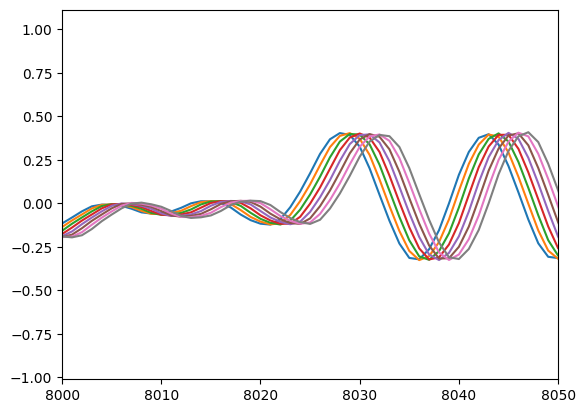

In [248]:
for i in range(M):
    plt.plot(X[i,:])

plt.xlim([8000,8050])

In [281]:
thetas = torch.linspace(0,180,100)
directivity = torch.log(lin_arr.eval_directivity(thetas,30) + 1e-2) #Ntheta by Nf

Multiangle: torch.Size([8, 100, 257])
Singleangle: torch.Size([8, 257])


In [282]:
print(directivity.shape)

torch.Size([100, 257])


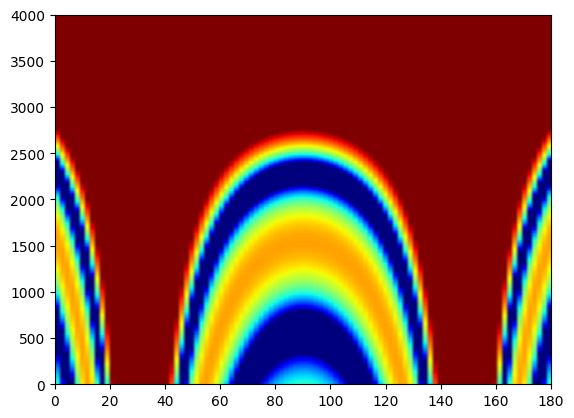

In [283]:
plt.imshow(directivity.transpose(-1,-2),aspect='auto',extent=[0,180,0,fs/2], clim=(-1,2),cmap = 'jet')